<a href="https://colab.research.google.com/github/tuxsy/iebs-master-data-science/blob/main/m06/proyecto_ml_completo/End_to_End_ML_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade scikit-learn

**Este ejemplo sigue en su mayoría todas las etapas de un CICLO DE VIDA COMPLETO DE UN PROYECTO MACHINE LEARNING, tal y como se muestra en la siguiente figura:**

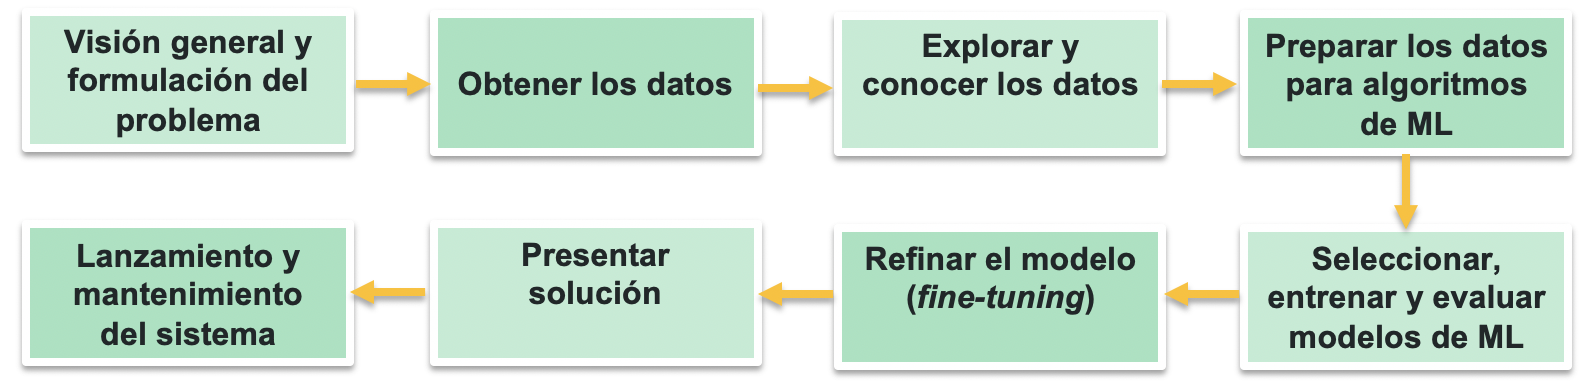

# 1: Visión general y formulación del problema

Suponer un proyecto en el que nos piden construir un **modelo predictivo del precio de la vivienda en el estado de California**. Se nos brindan **datos** históricos sobre la población, nivel de ingresos y precio de la vivienda **de cada distrito en California**.

Nuestro modelo debería ser capaz de **predecir la mediana del precio de la vivienda en cualquier distrito**, dado el resto de la información sobre tal distrito.

En esta primera etapa, debemos determinar el **objetivo de negocio** y transladar el problema real a una propuesta de solución de **Machine Learning**:
*   ¿Cuál es la solución actual existente, y qué aspectos pueden mejorarse?
*   ¿Cómo espera la compañía o entidad cliente beneficiarse de la nueva solución?
*   ¿Se trata de un problema predictivo, descriptivo, etc.? ¿Se precisa de una tarea de clasificación, regresión, agrupamiento, etc.?
*   ¿Aprendizaje supervisado, no supervisado o por refuerzo?
*   ¿Qué algoritmos seleccionar?
*   ¿Qué medidas emplear para evaluar su rendimiento?
*   Etc.

#2: Obtención de los datos

Para este proyecto, usaremos un conjunto de datos disponibles en el repositorio *Kaggle* sobre el precio de la vivienda en California ([Link](https://www.kaggle.com/camnugent/california-housing-prices))


In [1]:
! pip install kaggle
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download camnugent/california-housing-prices
! unzip california-housing-prices.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.8/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.8/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
unzip:  cannot find or open california-housing-prices.zip, california-housing-prices.zip.zip or california-housing-prices.zip.ZIP.


Volcamos los datos existentes en el fichero "housing.csv", que son los que nos interesan, en una estructura de datos proporcionada por la librería *pandas*, llamada *DataFrame*.

Echamos un primer vistazo a estos datos con las funciones *info()* y *describe()*. 

In [ ]:
import pandas as pd

housing = pd.read_csv("housing.csv")
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Otro modo de ver el aspecto general de nuestros datos, es con un **histograma** de cada uno de los atributos, donde tendremos una idea general del rango de valores que existen en cada atributo, valores más y menos frecuentes, etc.

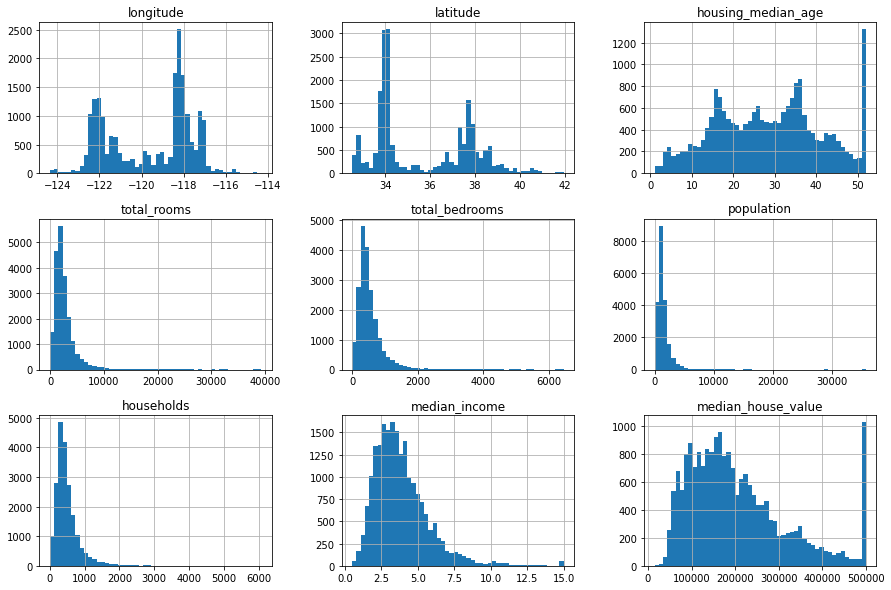

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins = 50, figsize=(15,10))
plt.show() #Opcional en libretas Jupyter

**Creación de un conjunto de Test**

Consideraciones importantes para separar los datos en un **conjunto de entrenamiento** y un **conjunto de test**:



*   Escoger aleatoriamente un 20% del dataset original, o un porcentaje menor si el dataset es muy grande.
*   ***Muestreo aleatorio*** funciona bien para datos suficientemente grandes, pero si no lo es, existe el riesgo de introducir **sesgo por muestreo**.
*  El ***muestreo estratificado*** procura **preservar las proporciones existentes en los datos (estratos)**, asegurando un conjunto de tests representativo del total. Esto es especialmente importante cuando sabemos a priori que cierto(s) atributo(s) son buenos predictores.
*  Es importante tener un número suficiente de instancias para cada estrato: no crear demasiados estratos y que cada uno de ellos sea lo suficientemente grande.





**Ejemplo**: Suponer que nos informan de que la mediana de ingresos (*median income*) es un buen predictor del precio de una vivienda.

Dado que es un atributo continuo, **para realizar un muestreo estratificado** de los datos que nos ayude a dividirlos en entrenamiento-test, necesitamos en primer lugar **convertir el atributo en discreto o categórico**, donde **cada categoria representará un estrato**.

Para ello, creamos un atributo categórico llamado *income_cat* mediante discretización de los valores de *median_income* en cubetas:



In [ ]:
import numpy as np

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

Seguidamente, usamos la clase **StratifiedShuffleSplit** de scikit-learn para particionar el dataset en entrenamiento (80%) y test (20%) usando como criterio del muestro estratificado el recién creado atributo *income_cat*.

Tras esto, ya no necesitamos este atributo, asi que lo eliminamos del *dataset*.

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]

for set_ in (strat_train_set, strat_test_set):
  set_.drop("income_cat", axis=1, inplace=True)

# 3: Explorando y conociendo los datos

Para profundizar más en los datos, ahora que han sido particionados en entrenamiento y test, es buena idea **dejar a un lado cuidadosamente el conjunto de test** y **poner el foco en los datos de entrenamiento**.

En primer lugar, haremos una "copia de seguridad" estos para evitar alterarlo durante esta exploración.

Tras ello, realizamos una visualización sencilla de dos de sus atributos asociados a información geográfica: *longitude* y *latitude*. Se plica un nivel de transparencia a los puntos visualizados (alpha = 0.1) para poder apreciar mejor las zonas con mayor densidad de datos.

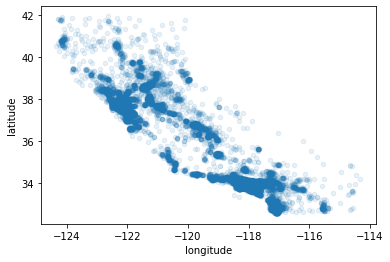

In [ ]:
housing = strat_train_set.copy()
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

Incorporar más información a la anterior visualización:


*   Con la opción ***s*** (*size*), controlamos el tamaño de los puntos de modo que describan otro atributo, en este caso el tamaño de la población en un distrito (*population*). La división entre 100 es para evitar puntos demasiado grandes.
*   Con la opción ***c*** (*color*), se asignan colores a diferentes valores del atributo indicado; en este caso el valor mediano de los hogares en el distrito (*median_house_value*). 
* ***cmap*** permite elegir la paleta de colores, siendo "jet" una de ellas. Existen muchas otras, p.ej. "Dark2", "rainbow", "magma", ...



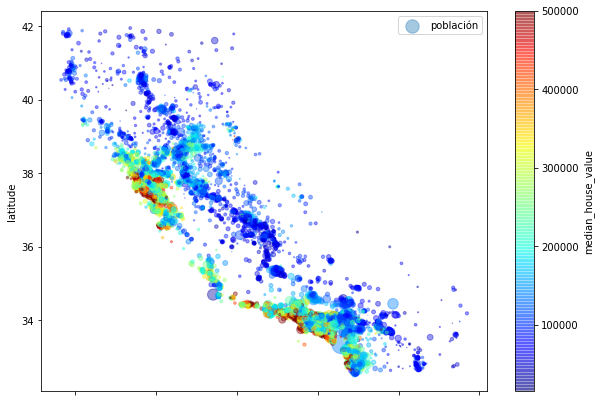

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="población", figsize=(10,7),
             c="median_house_value", cmap = plt.get_cmap("jet"), colorbar=True
             )

**Calcular la matrix de correlación *lineal* entre atributos**

Viable cuando no existen demasiados atributos ni datos en general.
El coeficiente de correlación de Pearson arroja valores entre -1 y 1, siendo los valores positivos indicadores de correlación lineal positiva, valores negativos indican correlación lineal negativa, y valores cercanos a 0 indican que no existe correlación lineal.

In [ ]:
corr_matrix = housing.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105823,0.048909,0.076686,0.108071,0.063146,-0.019615,-0.047466
latitude,-0.924478,1.000000,0.005737,-0.039245,-0.072550,-0.115290,-0.077765,-0.075146,-0.142673
housing_median_age,-0.105823,0.005737,1.000000,-0.364535,-0.325101,-0.298737,-0.306473,-0.111315,0.114146
total_rooms,0.048909,-0.039245,-0.364535,1.000000,0.929391,0.855103,0.918396,0.200133,0.135140
total_bedrooms,0.076686,-0.072550,-0.325101,0.929391,1.000000,0.876324,0.980167,-0.009643,0.047781
population,0.108071,-0.115290,-0.298737,0.855103,0.876324,1.000000,0.904639,0.002421,-0.026882
households,0.063146,-0.077765,-0.306473,0.918396,0.980167,0.904639,1.000000,0.010869,0.064590
median_income,-0.019615,-0.075146,-0.111315,0.200133,-0.009643,0.002421,0.010869,1.000000,0.687151
median_house_value,-0.047466,-0.142673,0.114146,0.135140,0.047781,-0.026882,0.064590,0.687151,1.000000


Cabe destacar que las correlaciones entre *median_house_value* y los atributos de entrada podrían darnos una primera aproximación de si algún atributo(s) será un buen predictor del valor a estimar mediante regresión.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f38ddb76250>,
      dtype=object)

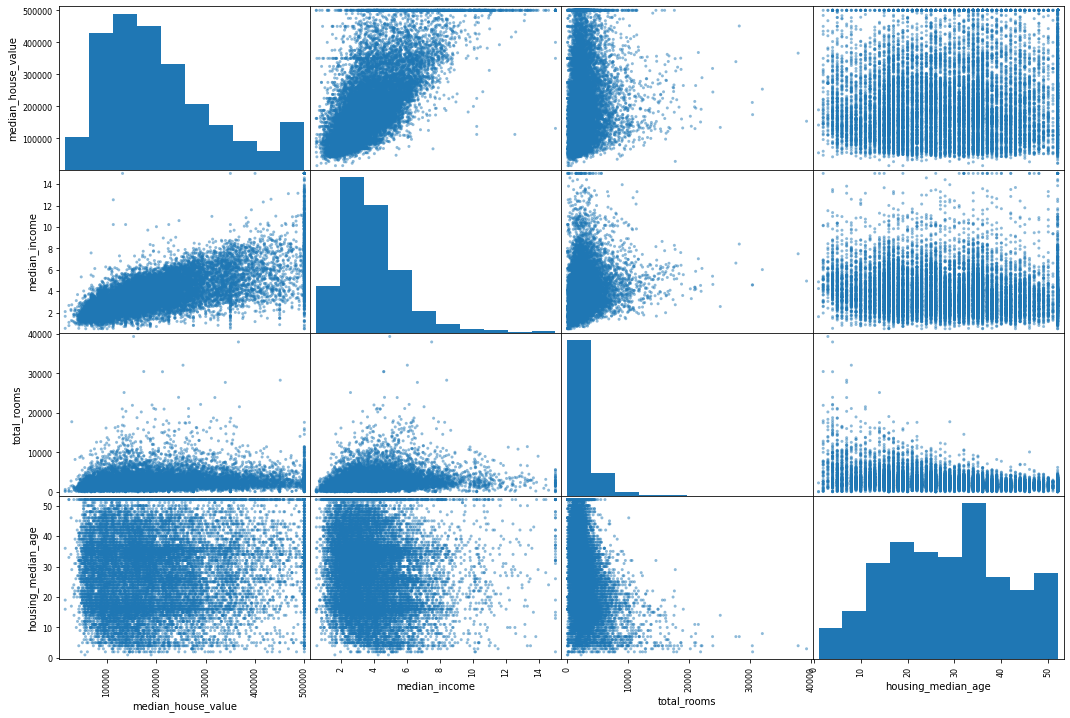

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(18,12))

***Probar combinaciones de atributos:***

Por último, exploramos formas de combinar atributos que den lugar a atributos más útiles o interpretables. Por ejemplo:



*   Ratio de dormitorios = Dormitorios por distrito / Habitaciones por distrito
*   Población media por hogar = Población total / \#hogares por distrito

*   Habitaciones por hogar = ***???***

***PROPUESTO***: Realizar un nuevo análisis de correlaciones y observar si alguno de los nuevos atributos muestra cierta correlación con la variable a predecir, *median_house_value*.

In [ ]:
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]
#corr_matrix = housing.corr()
#corr_matrix

# 4: Preparar los datos para los algoritmos de Machine Learning

Tras la anterior exploración, ***volvemos a tomar los datos de entrenamiento*** obtenidos al finalizar la fase 2, pero esta vez **separando los atributos predictores y el atributo (dependiente) a predecir** (etiquetas, *labels*).

In [ ]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## 4.1: Limpieza de Datos

Cuando los datos presentan ***valores perdidos*** en algún atributo, es necesario realizar un tratamiento de los mismos. Posibles soluciones:


1.   Eliminar instancias (distritos) que contengan valores perdidos.
2.   Eliminar el atributo que presenta valores perdidos.
3.   ***Asignar (imputar) un valor que reemplace a los valores perdidos***: cero, media, mediana, ...

Si se escoge la tercera opción, es importante conservar el valor "por defecto", p.ej. la mediana, para más adelante reemplazar valores perdidos en el ***conjunto de test*** a la hora de evaluar nuestro sistema.

La clase **SimpleImputer** permite rellenar valores perdidos de acuerdo a una estrategia elegida: *mean, median, most_frequent*, ...



In [ ]:
total_bedrooms_median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(total_bedrooms_median, inplace=True)

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

Antes de aplicar el **SimpleImputer** a nuestros datos, hay que realizar una copia de estos sin los atributos no numéricos, para evitar errores.

Uno de los usos del método **fit** (uno de los métodos centrales de toda la librería scikit-learn) es el de estimar parámetros en base a un dataset. En este caso, en la clase ***SimpleImputer*** se encarga de estimar la mediana de cada atributo.

In [ ]:
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

SimpleImputer(strategy='median')

Acto seguido, el método ***transform*** se encarga de "rellenar" los valores perdidos con las medianas estimadas, devolviendo como resultado otro dataset.

Los datos resultantes de llamar a ***transform*** no quedan almacenados en un *DataFrame* de *pandas*, no obstante volver a colocarlos en un DataFrame es sencillo:

In [ ]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

#Se pueden observar los valores de las medianas de cada atributo, calculadas por el método fit de SimpleImputer:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

##4.2: Manejo de datos categóricos y de texto

Solamente disponemos de un atributo no numérico, *ocean_proximity*, así que nos centraremos en él. En primer lugar lo extraemos y observamos algunos de sus valores:

In [ ]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


A simple vista, no se trata de un atributo puramente textual, sino categórico con un número reducido de posibles valores. Por ello, podemos codificar estos valores como números (usando la clase ***OrdinalEncoder***):

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]
#ordinal_encoder.categories_

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

Sin embargo, esta solución no es adecuada. La codificación resultante no captura el orden lógico entre las categorías (0 = '<1H ocean', 1 = 'Near ocean', ...).

Una mejor solución es ***crear un atributo binario para cada categoría*** con la clase ***OneHotEncoder***, indicando la presencia o ausencia de esta en cada observación. Asi pasamos de tener un atributo categórico con 5 posibles valores, a tener 5 atributos binarios:

In [ ]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

#Opcionalmente, convertir el resultado por defecto (sparse matrix) en un array convencional:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

**Cuando el número de posibles categorías es muy elevado**, desplegar el atributo en multitud de atributos binarios tampoco es buena idea, ya que **degradará la eficiencia del modelo de Machine Learning**. En estos casos es mejor aprender una representación compacta llamada *embedding* (no se verá en este tutorial).

##4.3: Funciones de transformación a medida

Un aspecto algo más avanzado que Scikit-learn permite es **crear clases a medida para realizar procesos de transformación** definidos por el desarrollador. 


En el siguiente ejemplo **ampliamos el dataset introduciendo nuevos atributos**: concretamente las **creados anteriormente por agregación de los atributos base**.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_index, bedrooms_index, population_index, households_index = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
  
  def __init__(self, add_bedrooms_per_room = True):
    self.add_bedrooms_per_room = add_bedrooms_per_room

  def fit(self, X, y=None):
    return self 
    #No es necesario hacer nada aqui

  def transform(self, X):
    rooms_per_household = X[:, rooms_index] / X[:, households_index]
    population_per_household = X[:, population_index] / X[:, households_index]
    if self.add_bedrooms_per_room:
      bedrooms_per_room = X[:, bedrooms_index] / X[:, rooms_index]
      return np.c_[X, rooms_per_household, population_per_household,
                   bedrooms_per_room]
    else:
      return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room = False)
housing_extra_attributes = attr_adder.transform(housing.values)


## 4.4: Escalado de atributos

Suele ser **una de las transformaciones más habituales e importantes** a aplicar en nuestros datos, para asegurar un buen funcionamiento de los algoritmos de *Machine Learning*. 

**IMPORTANTE**: *al igual que toda transformación de los datos, ésta debe ajustarse a los datos de entrenamiento, no al conjunto completo de datos.*

Se distinguen dos formas típicas de pasar los atributos a la misma escala: *escalado min-max* y *estandarización*.

*  El escalado min-max o **normalización** se trata en la 
mayoría de casos de normalizar valores al rango 0-1: restando a cada valor el mínimo del atributo correspondiente y dividiendo por la diferencia entre el máximo y el mínimo (usar la clase transformer **MinMaxScaler** de *scikit-learn* ajustando opcionalmente el hiperparámetro *feature_range*):

$$\hat{x} = \frac{x - min}{max - min}$$

*  La **estandarización** resta el valor promedio y divide por la desviación estándar. Aunque no limita los valores a un rango especificado -lo cual puede ser un problema en redes neuronales que suelen trabajar con entradas normalizadas- en general este método es mucho menos sensible a *outliers* (datos "alejados" de la mayoría). Se utiliza mediante la clase transformer **StardardScaler** de *scikitlearn*.

$$\hat{x} = \frac{x - \overline{\textbf{x}}}{\sigma_\textbf{x}}$$

##4.5: Secuencias de transformaciones en los datos: **Pipelines**

[**LINK**: Displaying Pipelines in scikit-learn](https://scikit-learn.org/dev/auto_examples/miscellaneous/plot_pipeline_display.html#sphx-glr-auto-examples-miscellaneous-plot-pipeline-display-py)

Normalmente, un proceso de **Machine Learning** implica aplicar una serie de transformaciones: paso a paso, y en el orden correcto.

*scikit-learn* proporciona una clase para encapsular secuencias de transformaciones a medida, también llamadas *Pipelines*: esta clase es **Pipeline**. Su método constructor toma una lista de estimadores, debiendo todos menos el último de ellos ser transformadores (*transformers*) que tengan el método *fit_transform*.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import set_config

num_data_pipeline = Pipeline([
                              ('imputer', SimpleImputer(strategy="median")),
                              ('attribs_adder', CombinedAttributesAdder()),
                              ('std_scaler', StandardScaler()),
  ])
set_config(display="diagram") #Esta configuración hace posible visualizar un diagrama del proceso a aplicar.
num_data_pipeline

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('attribs_adder', CombinedAttributesAdder()),
                ('std_scaler', StandardScaler())])

In [ ]:
housing_num_tr = num_data_pipeline.fit_transform(housing_num)

La anterior secuencia se aplica únicamente a los datos de atributos numéricos. Para tener un único Pipeline que incluya también los atributos categórico, se puede usar la clase **ColumnTransformer**.

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
                                   ("numerical attributes", num_data_pipeline, num_attribs),
                                   ("categorical attributes", OneHotEncoder(), cat_attribs),
  ])

set_config(display="diagram")
full_pipeline

ColumnTransformer(transformers=[('numerical attributes',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('attribs_adder',
                                                  CombinedAttributesAdder()),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income']),
                                ('categorical attributes', OneHotEncoder(),
                                 ['ocean_proximity'])])

In [ ]:
housing_prepared = full_pipeline.fit_transform(housing)

#5: Seleccionar, entrenar y evaluar un modelo de Machine Learning

Una vez definido el problema, obtenidos, explorados y preparados los datos, ¡es hora de jugar con los modelos de Machine Learning!

Gracias a la librería *scikit-learn* y al (tedioso) proceso de preparación de los datos llevado a cabo en etapas anteriores, la creación y utilización de un modelo de *Machine Learning* que veremos a continuación -concretamente de **regresión lineal**- será bastante sencilla:

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels) #El método 'fit' entrena el modelo de regresión, 
                                              #ajustando los datos de entrenamiento en 'housing_prepared'
                                              #al conjunto de etiquetas asociadas a los mismos en 'housing_labels'.

LinearRegression()

Vamos a probar el modelo de regresión lineal recién entrenado, intentando predecir el precio de unas pocas viviendas extraídas de los propios datos de entrenamiento.

In [ ]:
some_data = housing.iloc[:10]
some_labels = housing_labels.iloc[:10]
some_data_prepared = full_pipeline.transform(some_data) #¿Recuerdas? Definimos esta secuencia de transformaciones
                                                        #para preparar nuestros datos en el apartado 4.5
print("Predicciones de prueba: ", lin_reg.predict(some_data_prepared))
print("Etiquetas o valores reales (labels) :", list(some_labels))

Predicciones de prueba:  [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089 206382.40770567 376422.05961781 266569.80764938
 151001.79721225  30119.48436056]
Etiquetas o valores reales (labels) : [72100.0, 279600.0, 82700.0, 112500.0, 238300.0, 165700.0, 412300.0, 349600.0, 181300.0, 500001.0]


A primera vista, el modelo funciona -es capaz de realizar predicciones- pero no parece muy acertado ;-)

Veamos cómo de bueno (o malo!) es midiendo la raíz del error cuadrático medio, **Root Mean Squared Error (RMSE)**, en todo el conjunto de datos de entrenamiento:

In [ ]:
from sklearn.metrics import mean_squared_error
housing_tr_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_tr_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68627.87390018745

Así, el **error típico** de las predicciones hechas sobre los datos de entrenamiento (los propios datos que se han usado precisamente para construir el modelo) no es muy prometedor: unos $68.628 como margen de error.

Este es un claro de ejemplo de un modelo pobremente ajustado a los datos de entrenamiento o ***underfitting***. Un posible motivo por el que el modelo no ha "sabido" ajustarse bien a los datos, es que (i) sus atributos podrían no contener información suficiente para hacer buenas predicciones, o bien que (ii) el modelo de regresión lineal no es el más adecuado para estos datos.

A veces la solución pasa por *añadir nuevos atributos*, incluyendo atributos derivados de los originales; pero vale la pena en primer lugar intentar *probar otro modelo* de regresión: por ejemplo un **regresor basado en árboles de decisión**. Esta técnica es conocida por ser capaz de encontrar relaciones complejas y no lineales en los datos, por lo que están menos limitadas que una simple recta de regresión lineal:

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor() #Inicializar modelo
tree_reg.fit(housing_prepared, housing_labels) #Entrenar modelo con los datos y etiquetas de entrenamiento

housing_tr_predictions = tree_reg.predict(housing_prepared) #Realizar predicciones sobre los propios datos de entrenamiento
tree_mse = mean_squared_error(housing_labels, housing_tr_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse



0.0

Para sorpresa nuestra, la evaluación indica que **no hay error**. No cantemos victoria, esto parece indicar que ahora el modelo construido -árbol de decisión- se sobreajusta a los datos de entrenamiento (***overfitting***) de forma exagerada.

Para saber si este es el caso -y en general en todo proyecto de Machine Learning- la verdadera evaluación debe pasar por **realizar predicciones más allá de los datos usados para entrenar y construir el modelo**.

##5.1: Evaluación mediante validación cruzada (Cross-Validation)

Este popular pero a veces costoso modo de evaluar un modelo recién entrenado, consiste en particionar aleatoriamente nuestro conjunto de entrenamiento en *K* subconjuntos (*folds*), y evaluar el modelo *K* veces, usando en cada una de ellas *K-1* folds para entrenar el modelo y el fold restante para evaluarlo/validarlo.

En *scikit-learn* se realiza de la siguiente forma (ejemplo con *K*=10 folds):

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

**ADVERTENCIA**: Pese a ser una forma muy realista de saber si nuestro modelo entrenado es bueno, la validación cruzada puede ser costosa ante grandes datos, ya que requiere entrenar el modelo *K* veces.

**CUIDADO**: La función de validación cruzada en *scikit-learn* mide utilidad y no coste (mayor es mejor). Por eso, para interpretarla como coste o error hay que negar los valores tras calcularlos.

El **resultado de la validación cruzada** es una lista de **valores de coste/error**: una **para cada uno de los *K* modelos entrenados**. El promedio de estos es un buen indicador de la bondad del algoritmo escogido, mientras que la desviación estandar nos dice cómo de confiable es este resultado.

In [ ]:
print("Valores de coste obtenidos: ", tree_rmse_scores)
print("Promedio: ", tree_rmse_scores.mean())
print("Desviación estándar: ", tree_rmse_scores.std())

Valores de coste obtenidos:  [72174.16690173 70808.5699466  69512.78040255 71020.35749504
 70217.34307998 77382.41082494 71463.89087262 73176.55729985
 69716.18854619 70362.21648425]
Promedio:  71583.4481853763
Desviación estándar:  2204.0573486818976


Así pues, el error ahora es incluso mayor que con el modelo de regresión lineal. ¡Una clara señal de que **el árbol de decisión estaba sobreajustándose severamente a los datos de entrenamiento**!

Comprobemos el resultado de una validación cruzada con el modelo de regresión lineal:

In [ ]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
print("Valores de coste obtenidos: ", lin_rmse_scores)
print("Promedio: ", lin_rmse_scores.mean())
print("Desviación estándar: ", lin_rmse_scores.std())


Valores de coste obtenidos:  [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Promedio:  69104.07998247063
Desviación estándar:  2880.3282098180607


Vamos a probar con un último tipo de técnica algo más sofisticada: regresión basada en bosque aleatorio o **random forest**. Es una técnica de aprendizaje por *ensembles* que combina muchos árboles de decisión entrenados en diferentes subconjuntos aleatorios de los atributos, seguido de un promedio de los resultados.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

housing_tr_predictions = forest_reg.predict(housing_prepared) #Realizar predicciones sobre los propios datos de entrenamiento
forest_mse = mean_squared_error(housing_labels, housing_tr_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18512.46358336664

In [ ]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
print("Valores de coste obtenidos: ", forest_rmse_scores)
print("Promedio: ", forest_rmse_scores.mean())
print("Desviación estándar: ", forest_rmse_scores.std())

Valores de coste obtenidos:  [51374.23519991 48998.03280456 46665.31186342 52210.27770561
 47693.466418   52175.50973735 52540.20327957 49921.20804125
 48336.84678652 54112.99534336]
Promedio:  50402.808717954365
Desviación estándar:  2312.3575519244164


El resultado ha mejorado mucho, pero todavía hay sobreajuste a los datos de entrenamiento, ya que el error inicial sobre el conjunto de entrenamiento es bastante inferior al error obtenido por validación cruzada.

**NO DESESPERES SI ESTA ÚLTIMA VALIDACIÓN REQUIERE UNOS MINUTOS DE EJECUCIÓN, ES NORMAL, DEBIDO A LA COMPLEJIDAD DE CONSTRUIR BOSQUES ALEATORIOS**.

**Posibles soluciones para reducir el sobreajuste** (*overfitting*):

*   Simplificar el modelo.
*   Restringir el modelo: **regularización**.
*   Obtener muchos más datos para el entrenamiento.
*   Probar otros tipos de técnicas de Machine Learning.

#6: Refinar el modelo (fine-tuning)

Cuando hemos identificado uno o varios modelos prometedores, la cosa no acaba ahí. ¡Hay que intentar optimizar su comportamiento! Veamos varias formas de hacerlo.

##6.1: Búsqueda en rejilla (Grid Search)

La forma más intuitiva de optimizar el rendimiento de un modelo es ajustar los hiperparámetros del mismo, encontrando una combinación idónea de estos. Dado que en la práctica esto supone una tediosa labor de exploración, *Scikit-learn* ofrece una forma de facilitar la ardua tarea con la clase **GridSearchCV**.

Con solo especificar qué hiperparámetros queremos explorar y que valores probar (lo que también se puede denominar una *rejilla de búsqueda*), **GridSearchCV** realiza una búsqueda de la **mejor combinación de hiperparámetros para nuestro modelo**:

In [ ]:
from sklearn.model_selection import GridSearchCV

# Definimos una rejilla de búsqueda con dos fases. 
# En la primera, se buscará la mejor combinación de los hiperparámetros 'n_estimators' y 'max_features'
# En la segunda, se buscará la mejor combinación de los mismos hiperparámetros, pero con 'bootstrap = False' 
param_grid = [
              {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
              {'bootstrap': [False], 'n_estimators': [3,10], 'max_features':[2,3,4]},
]

# Inicializar modelo basado en Random Forest
forest_reg = RandomForestRegressor()

# Asignar el modelo a una búsqueda en rejilla
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

# Entrenar el modelo
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

La búsqueda definida implica (3 x 4) + (2 x 3) = 18 combinaciones de hiperparámetros a probar. Para cada combinación a su vez se construirán 5 modelos ya que también se aplica validación cruzada con *cv=5*. Así, en total se realizan **18 x 5 = 90 rondas de entrenamiento**.

¿Cómo saber cuál es la mejor configuración del modelo que se ha encontrado tras tantísimas rondas de entrenamiento?

In [ ]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

¿Y cómo saber el resultado (error) arrojado por cada una de las 18 configuraciones?

In [ ]:
cvresults = grid_search.cv_results_
for mean_score, params in zip(cvresults["mean_test_score"], cvresults["params"]):
  print(np.sqrt(-mean_score), params)

63966.34305569873 {'max_features': 2, 'n_estimators': 3}
55585.533102569854 {'max_features': 2, 'n_estimators': 10}
52814.50320990613 {'max_features': 2, 'n_estimators': 30}
60236.87910271409 {'max_features': 4, 'n_estimators': 3}
53136.009966035475 {'max_features': 4, 'n_estimators': 10}
50256.49768207374 {'max_features': 4, 'n_estimators': 30}
59801.31698568794 {'max_features': 6, 'n_estimators': 3}
52369.29744486376 {'max_features': 6, 'n_estimators': 10}
49897.37861231966 {'max_features': 6, 'n_estimators': 30}
58323.600435960456 {'max_features': 8, 'n_estimators': 3}
51920.79975662254 {'max_features': 8, 'n_estimators': 10}
50212.745943945105 {'max_features': 8, 'n_estimators': 30}
61877.493497805684 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53936.14419780777 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60595.01573677887 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52780.24163092003 {'bootstrap': False, 'max_features': 3, 'n_estimators

##6.2: Búsqueda aleatoria

Más adecuada que la búsqueda en rejilla cuando el espacio de búsqueda de los hiperparámetros es muy amplio. La clase **RandomizedSearchCV** evalúa un número especificado de *combinaciones aleatorias* de hiperparámetros.

In [ ]:
from scipy.stats import truncnorm, randint
from sklearn.model_selection import RandomizedSearchCV

param_random = {
    # Muestra aleatoria para el hiperparámetro 'n_estimators' que es de tipo entero.
    'n_estimators': randint(4,200),
    # Distribución normal para 'max_features', con media .25, desviación estandar 0.1, y normalizada en 0-1
    'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
}

rrforest_reg = RandomForestRegressor()

# Entrenar 10 modelos -combinaciones aleatorias- sobre 5 'folds', (total 50 rondas)
# NOTA: En contextos reales hay que probar un valor de 'n_iter' mucho mayor, al menos de 100.
random_search = RandomizedSearchCV(rrforest_reg, param_random, n_iter=10, cv=5, random_state=1)
#random_search.fit(housing_prepared, housing_labels)

##6.3: Inspeccionar el papel jugado por los datos en el mejor modelo

Esto puede ayudar a ganar conocimiento extra sobre el problema inicialmente formulado y sobre los propios datos del mismo. Por ejemplo, echando un vistazo a la importancia relativa de cada atributo en nuestro modelo "estrella", el **RandomForestRegressor** con búsqueda en rejilla, podemos justificar y tomar decisiones futuras como descartar atributos con escasa importancia, buscar nuevos atributos, mejorar el proceso de limpieza de datos, etc.

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["categorical attributes"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
all_attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, all_attributes), reverse=True)

[(0.29270141298984526, 'median_income'),
 (0.16373346138511286, 'INLAND'),
 (0.10972558737175485, 'pop_per_hhold'),
 (0.09600355895731937, 'bedrooms_per_room'),
 (0.0775467539854892, 'longitude'),
 (0.06723397619373706, 'latitude'),
 (0.059922167391298346, 'rooms_per_hhold'),
 (0.042450691913163335, 'housing_median_age'),
 (0.017155471179037877, 'population'),
 (0.01651385770530869, 'total_rooms'),
 (0.01651098226746887, 'total_bedrooms'),
 (0.01632909956701716, 'households'),
 (0.01509503749738864, '<1H OCEAN'),
 (0.0045711132508723116, 'NEAR OCEAN'),
 (0.004469372987131725, 'NEAR BAY'),
 (3.745535805449785e-05, 'ISLAND')]

##6.4: Evaluar la solución final en el conjunto de datos de test

Finalmente, resulta imperativo ver cómo el mejor de los modelos encontrados se comporta con aquellos datos que dejamos apartados al inicio del proyecto como nuestro conjunto de test (véase final de **sección 2**). 

**IMPORTANTE**: Al someter al conjunto de test al mismo *pipeline* de transformaciones que se hicieron en los datos de entrenamiento, asegúrate de usar siempre la función *transform()*, y nunca *fit_transform()*, ¡ya que no queremos construir un modelo en base a los datos de test!

In [ ]:
final_model = grid_search.best_estimator_ #Seleccionar el mejor de los modelos R.F. que encontró la búsqueda en rejilla

X_test = strat_test_set.drop("median_house_value", axis=1) # Datos de entrada en el conjunto de test
y_test = strat_test_set["median_house_value"].copy() # Etiquetas en el conjunto de test

X_test_prepared = full_pipeline.transform(X_test) # Preparación de los datos de test, mediante pipeline (Sec 4.5).

test_predictions = final_model.predict(X_test_prepared) #Realizar las predicciones

test_mse = mean_squared_error(y_test, test_predictions) # Comparar las predicciones con las verdaderas etiquetas
test_rmse = np.sqrt(test_mse)
test_rmse

47054.4478674674

#7-8: Presentar solución, lanzamiento y mantenimiento del sistema

Finalmente, es el momento de presentar la solución a nuestro cliente, director, etc., documentar todo el trabajo realizado, y crear una llamativa presentación visual con mensajes potentes y fáciles de recordar sobre lo aprendido, por ejemplo: "***el ingreso mediano es el principal predictor del precio de la vivienda en California***".

Una vez nuestra propuesta ha sido aprobada, está lista para el proceso de **producción**, que puede incluir: pulir la presentación del código, escribir documentación e informes de los procesos de testeo, etc. 

**IMPORTANTE**: Guarda el/los mejor/es modelo(s) entrenado(s) usando *joblib*, incluyendo los procesos de preprocesamiento y producción. De este modo, será más sencillo cargar en el futuro este modelo en el entorno de producción y empezar a realizar *predict()* de forma casi inmediata. 

In [ ]:
import joblib

# GUARDAR UN MODELO YA ENTRENADO Y MEJORADO, PARA UTILIZARLO MÁS TARDE

filename = 'final_model.sav'
joblib.dump(final_model, filename)


# CARGAR UN MODELO ENTRENADO Y GUARDADO PREVIAMENTE EN DISCO

# loaded_model = joblib.load(filename)
# result = loaded_model.predict(X_test_prepared) #Realizar las predicciones

# test_mse = mean_squared_error(y_test, test_predictions) # Comparar las predicciones con las verdaderas etiquetas
#test_rmse = np.sqrt(test_mse)
# test_rmse

['final_model.sav']

Otros aspectos a considerar incluyen desplegar nuestro sistema en la nube, p.ej. en **Google Cloud AI Platform**, subiendo nuestro modelo previamente descargado con *joblib* en **Google Cloud Storage (GCS)**, creando una nueva versión de modelo que apunte al archivo GCS subido.

En cualquier caso, la historia no acaba con el despliegue de nuestro sistema. En la vida real hará falta escribir código para la monitorización y comprobación periódica del rendimiento del sistema, lanzando mensajes de alerta cuando dicho rendimiento decaiga. 

La razón es simple: ***El mundo está en constante cambio, y los datos de los que se nutre todo sistema inteligente (y de ML por supuesto) no son la excepción***. Un modelo entrenado con los datos de ayer, no estará perfectamente preparado para su mejor funcionamiento con los datos de hoy.

##Mantenimiento y monitorización

A menudo es un proceso continuo que requiere de más esfuerzo que la construcción y entrenamiento inicial del modelo de *Machine Learning*.

Debido a que los datos disponibles en un entorno determinado suele evolucionar constantemente, es imprescindible actualizar nuestros *datasets* y re-entrenar nuestro(s) modelo(s) de forma regular. Por ello, conviene automatizar el proceso en la medida de lo posible:

*   Recolectando datos "frescos" regularmente y etiquetándolos si procede.
*   Escribiendo un *script* de código que se encarga de entrenar el modelo y refinar sus hiperparámetros de forma automática: ejecutarlo cada día, o cada semana, etc., dependiendo del problema.
*   Escribiendo otro *script* que compare el rendimiento del nuevo modelo con el de la versión anterior sobre los nuevos datos de test: desplegar la nueva versión a producción solo si el rendimiento no ha empeorado.

No olvidar velar siempre por la calidad de los nuevos datos que irán nutriendo nuevas versiones de nuestros modelos. Esto ayuda a detectar posibles deterioros en el rendimiento de forma más temprana.

Por último, mantener copias de seguridad no solo de los modelos entrenados, sino también de diferentes versiones de los datasets (para mitigar la eventualidad de que en un momento dado llegan datos corruptos).